In [29]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder.appName("LinearRegression").getOrCreate()

### 1. Data Loading and Initial Inspection

The process begins by loading the `Employe_Performance_dataset.csv` file into a Spark DataFrame and displaying the first few rows to understand the data structure and content.

In [30]:
df = spark.read.csv("/content/Employe_Performance_dataset.csv", header=True, inferSchema=True)
df.show()

+---+------------------+---+------+----------+------+------------+-----------------+----------+--------+-----------+-------+
| ID|              Name|Age|Gender|Department|Salary|Joining Date|Performance Score|Experience|  Status|   Location|Session|
+---+------------------+---+------+----------+------+------------+-----------------+----------+--------+-----------+-------+
|  1|      Cory Escobar| 48|Female|        HR|  5641|  2015-05-03|              2.0|        16|  Active|   New York|  Night|
|  2|   Timothy Sanchez| 25| Other|     Sales|  4249|  2020-11-09|              2.0|        11|Inactive|Los Angeles|Evening|
|  3|      Chad Nichols| 57| Other|     Sales|  3058|  2019-02-12|             NULL|         1|Inactive|   New York|Morning|
|  4|Christine Williams| 58|Female|        IT|  5895|  2017-09-08|              2.0|        13|Inactive|Los Angeles|Evening|
|  5|      Amber Harris| 35| Other|        IT|  4317|  2020-02-15|              5.0|        16|Inactive|   New York|Evening|


### 2. Data Cleaning and Preparation

Missing values in the 'Performance Score' column were imputed using the mode of the column. A new feature, 'Tenure', was engineered by calculating the difference in years between the current date and the 'Joining Date'.

In [31]:
mode_df = df.select(mode("Performance Score")).collect()[0][0]
df = df.fillna({"Performance Score":mode_df})
df.show()

+---+------------------+---+------+----------+------+------------+-----------------+----------+--------+-----------+-------+
| ID|              Name|Age|Gender|Department|Salary|Joining Date|Performance Score|Experience|  Status|   Location|Session|
+---+------------------+---+------+----------+------+------------+-----------------+----------+--------+-----------+-------+
|  1|      Cory Escobar| 48|Female|        HR|  5641|  2015-05-03|              2.0|        16|  Active|   New York|  Night|
|  2|   Timothy Sanchez| 25| Other|     Sales|  4249|  2020-11-09|              2.0|        11|Inactive|Los Angeles|Evening|
|  3|      Chad Nichols| 57| Other|     Sales|  3058|  2019-02-12|              2.0|         1|Inactive|   New York|Morning|
|  4|Christine Williams| 58|Female|        IT|  5895|  2017-09-08|              2.0|        13|Inactive|Los Angeles|Evening|
|  5|      Amber Harris| 35| Other|        IT|  4317|  2020-02-15|              5.0|        16|Inactive|   New York|Evening|


In [32]:
df = df.withColumn("Tenure",year(current_date())-year(to_date(df["Joining Date"])))
df.show()

+---+------------------+---+------+----------+------+------------+-----------------+----------+--------+-----------+-------+------+
| ID|              Name|Age|Gender|Department|Salary|Joining Date|Performance Score|Experience|  Status|   Location|Session|Tenure|
+---+------------------+---+------+----------+------+------------+-----------------+----------+--------+-----------+-------+------+
|  1|      Cory Escobar| 48|Female|        HR|  5641|  2015-05-03|              2.0|        16|  Active|   New York|  Night|    10|
|  2|   Timothy Sanchez| 25| Other|     Sales|  4249|  2020-11-09|              2.0|        11|Inactive|Los Angeles|Evening|     5|
|  3|      Chad Nichols| 57| Other|     Sales|  3058|  2019-02-12|              2.0|         1|Inactive|   New York|Morning|     6|
|  4|Christine Williams| 58|Female|        IT|  5895|  2017-09-08|              2.0|        13|Inactive|Los Angeles|Evening|     8|
|  5|      Amber Harris| 35| Other|        IT|  4317|  2020-02-15|          

### 3. Feature Engineering

Categorical features 'Session' and 'Gender' were converted into numerical indices using StringIndexer. These indexed features, along with 'Experience' and 'Tenure', were assembled into a single feature vector using VectorAssembler for use in the machine learning model.

In [33]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
strIdx = StringIndexer(inputCol="Session",outputCol="Session_Idx")
df = strIdx.fit(df).transform(df)
df.show()

+---+------------------+---+------+----------+------+------------+-----------------+----------+--------+-----------+-------+------+-----------+
| ID|              Name|Age|Gender|Department|Salary|Joining Date|Performance Score|Experience|  Status|   Location|Session|Tenure|Session_Idx|
+---+------------------+---+------+----------+------+------------+-----------------+----------+--------+-----------+-------+------+-----------+
|  1|      Cory Escobar| 48|Female|        HR|  5641|  2015-05-03|              2.0|        16|  Active|   New York|  Night|    10|        0.0|
|  2|   Timothy Sanchez| 25| Other|     Sales|  4249|  2020-11-09|              2.0|        11|Inactive|Los Angeles|Evening|     5|        2.0|
|  3|      Chad Nichols| 57| Other|     Sales|  3058|  2019-02-12|              2.0|         1|Inactive|   New York|Morning|     6|        1.0|
|  4|Christine Williams| 58|Female|        IT|  5895|  2017-09-08|              2.0|        13|Inactive|Los Angeles|Evening|     8|     

In [34]:
genderIdx = StringIndexer(inputCols=["Gender"], outputCols=["GenderIdx"])
df = genderIdx.fit(df).transform(df)
df.show()

+---+------------------+---+------+----------+------+------------+-----------------+----------+--------+-----------+-------+------+-----------+---------+
| ID|              Name|Age|Gender|Department|Salary|Joining Date|Performance Score|Experience|  Status|   Location|Session|Tenure|Session_Idx|GenderIdx|
+---+------------------+---+------+----------+------+------------+-----------------+----------+--------+-----------+-------+------+-----------+---------+
|  1|      Cory Escobar| 48|Female|        HR|  5641|  2015-05-03|              2.0|        16|  Active|   New York|  Night|    10|        0.0|      1.0|
|  2|   Timothy Sanchez| 25| Other|     Sales|  4249|  2020-11-09|              2.0|        11|Inactive|Los Angeles|Evening|     5|        2.0|      0.0|
|  3|      Chad Nichols| 57| Other|     Sales|  3058|  2019-02-12|              2.0|         1|Inactive|   New York|Morning|     6|        1.0|      0.0|
|  4|Christine Williams| 58|Female|        IT|  5895|  2017-09-08|          

In [35]:
df.show(10)

+---+------------------+---+------+----------+------+------------+-----------------+----------+--------+-----------+-------+------+-----------+---------+
| ID|              Name|Age|Gender|Department|Salary|Joining Date|Performance Score|Experience|  Status|   Location|Session|Tenure|Session_Idx|GenderIdx|
+---+------------------+---+------+----------+------+------------+-----------------+----------+--------+-----------+-------+------+-----------+---------+
|  1|      Cory Escobar| 48|Female|        HR|  5641|  2015-05-03|              2.0|        16|  Active|   New York|  Night|    10|        0.0|      1.0|
|  2|   Timothy Sanchez| 25| Other|     Sales|  4249|  2020-11-09|              2.0|        11|Inactive|Los Angeles|Evening|     5|        2.0|      0.0|
|  3|      Chad Nichols| 57| Other|     Sales|  3058|  2019-02-12|              2.0|         1|Inactive|   New York|Morning|     6|        1.0|      0.0|
|  4|Christine Williams| 58|Female|        IT|  5895|  2017-09-08|          

### 4. Exploratory Data Analysis (EDA)

Several visualizations were generated to explore the relationships between different features:

*   **Department Distribution:** A pie chart shows the percentage of employees in each department.
*   **Salary vs. Experience:** A line plot visualizes the average salary across different experience levels.
*   **Employee Status Distribution:** A bar chart displays the number of active and inactive employees.
*   **Session vs. Experience:** A grouped bar chart illustrates the distribution of employee sessions by experience level.
*   **Average Salary by Department and Gender:** A grouped bar chart shows the average salary for each gender within each department.
*   **Average Salary by Department and Tenure:** Average salary is shown for each department and tenure combination.
*   **Average Salary by Tenure:** A bar chart displays the average salary across different tenure levels.
*   **Average Salary by Department and Status:** A grouped bar chart shows the average salary for active and inactive employees within each department.

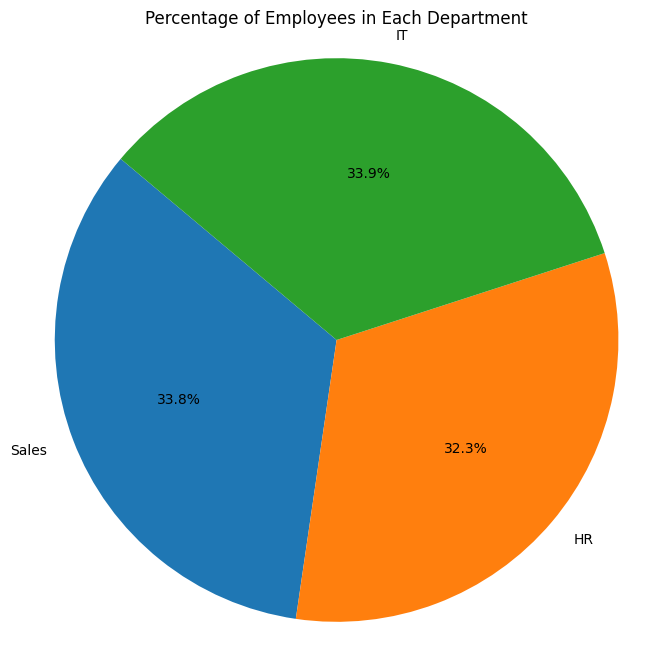

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

department_counts = df.groupBy("Department").count()
department_counts_pd = department_counts.toPandas()

plt.figure(figsize=(8, 8))
plt.pie(department_counts_pd['count'], labels=department_counts_pd['Department'], autopct='%1.1f%%', startangle=140)
plt.title('Percentage of Employees in Each Department')
plt.axis('equal')
plt.show()

## Salary vs experience


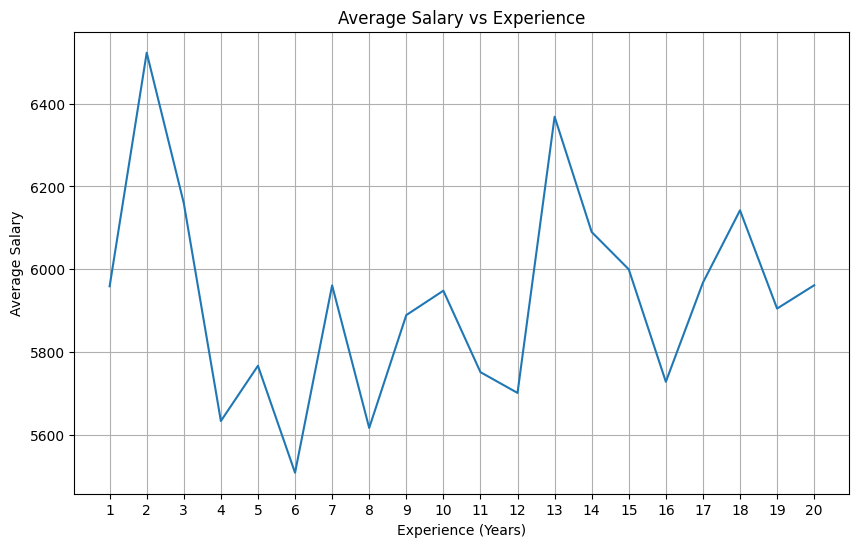

In [37]:
import matplotlib.pyplot as plt
import pandas as pd # Import pandas for plotting

# Group by Experience and calculate the average salary
experience_salary = df.groupBy("Experience").agg(avg("Salary").alias("Average Salary"))

# Convert to Pandas DataFrame
experience_salary_pd = experience_salary.toPandas()

# Sort by Experience for better visualization
experience_salary_pd = experience_salary_pd.sort_values(by='Experience')

plt.figure(figsize=(10, 6))
# Create a line plot of average salary vs experience
plt.plot(experience_salary_pd['Experience'], experience_salary_pd['Average Salary'])
plt.xlabel('Experience (Years)')
plt.ylabel('Average Salary')
plt.title('Average Salary vs Experience')
plt.xticks(experience_salary_pd['Experience']) # Set ticks to be the experience years
plt.grid(True)
plt.show()

### Employee Status vs No. of Employees


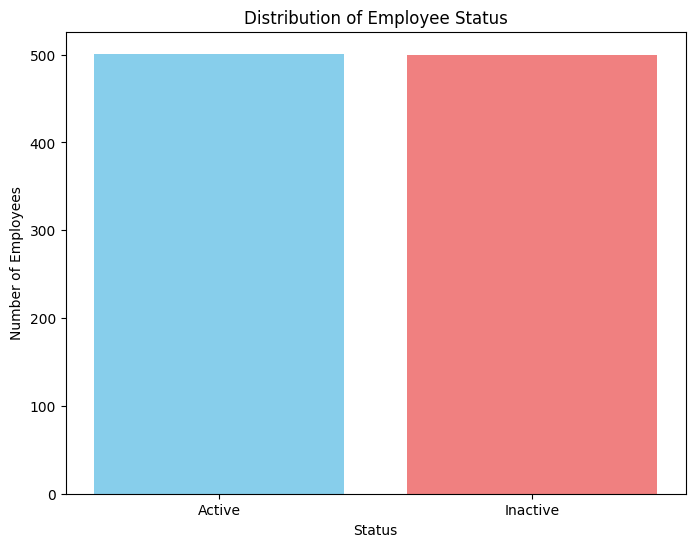

In [38]:
status_counts = df.groupBy("Status").count()
status_counts_pd = status_counts.toPandas()

plt.figure(figsize=(8, 6))
plt.bar(status_counts_pd['Status'], status_counts_pd['count'], color=['skyblue', 'lightcoral'])
plt.xlabel('Status')
plt.ylabel('Number of Employees')
plt.title('Distribution of Employee Status')
plt.show()

## Session vs experience

<Figure size 1500x800 with 0 Axes>

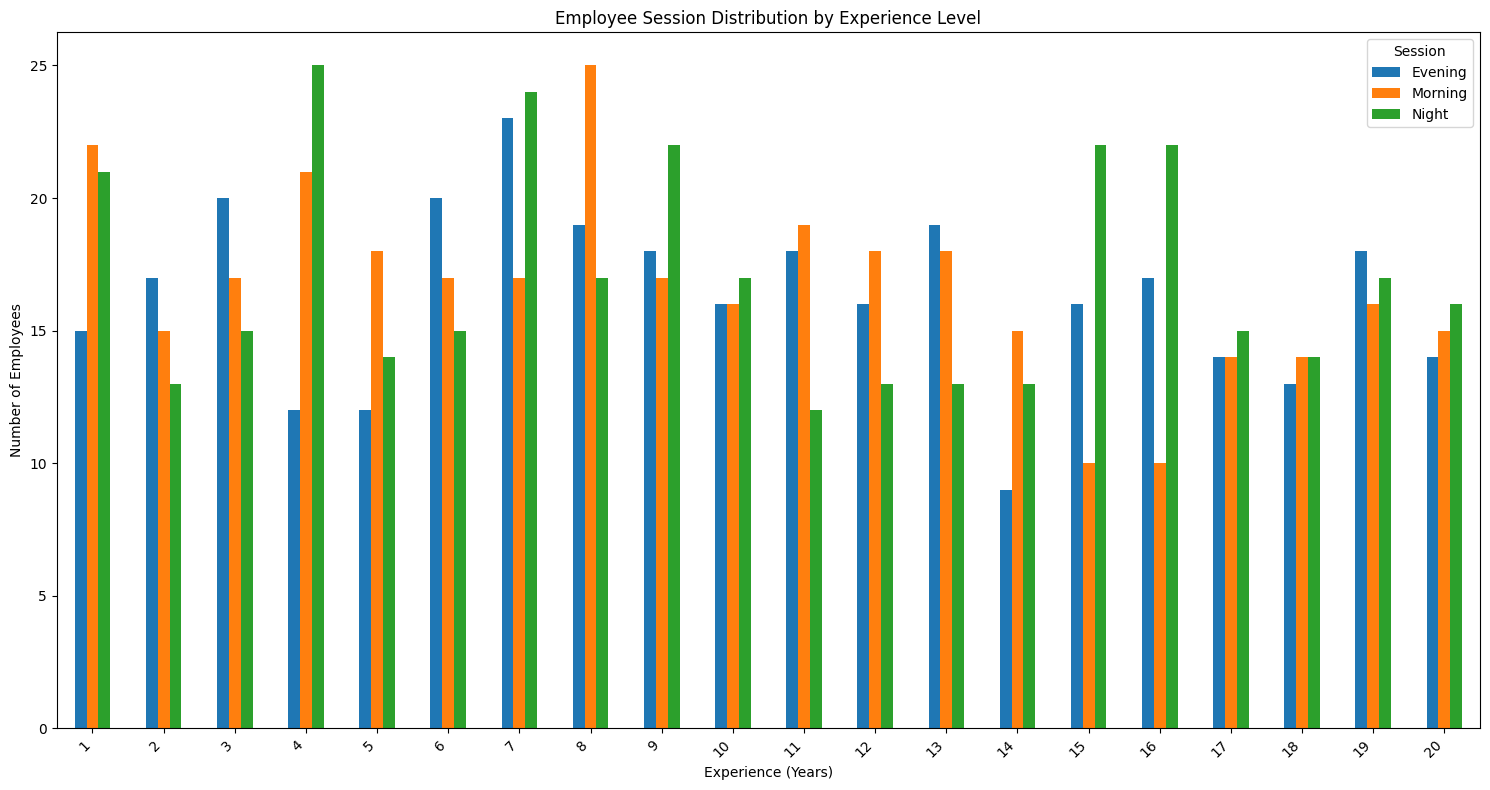

In [39]:
session_experience_counts = df.groupBy("Experience", "Session").count()
session_experience_counts_pd = session_experience_counts.toPandas()

pivot_df = session_experience_counts_pd.pivot(index='Experience', columns='Session', values='count').fillna(0)

plt.figure(figsize=(15, 8))
pivot_df.plot(kind='bar', figsize=(15, 8))
plt.xlabel("Experience (Years)")
plt.ylabel("Number of Employees")
plt.title("Employee Session Distribution by Experience Level")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   The distribution of employees across different departments was visualized using a pie chart.
*   A scatter plot of Salary versus Experience was successfully generated.
*   A bar graph comparing the number of active and inactive employees was generated, showing the distribution of employee status.
*   A grouped bar chart was successfully created and displayed, visualizing the relationship between Session and Experience levels.

### Insights or Next Steps

*   Analyze the specific percentage breakdown of employees in each department to identify potential areas for resource allocation or restructuring.
*   Investigate the correlation between Salary and Experience based on the scatter plot to understand the salary structure.
*   Examine the distribution of active and inactive employees to identify potential reasons for inactivity and strategies for re-engagement or workforce planning.
*   Further explore the relationship between Session and Experience levels to understand if certain experience groups are more prevalent in specific sessions and the implications for scheduling and resource management.


In [40]:
department_gender_salary = df.groupBy("Department", "Gender").agg(avg("Salary").alias("Average Salary"))
department_gender_salary.show()

+----------+------+------------------+
|Department|Gender|    Average Salary|
+----------+------+------------------+
|        IT|Female| 6118.203539823009|
|        HR|  Male| 6249.429752066116|
|        HR| Other| 5955.782178217822|
|     Sales|  Male| 5994.067307692308|
|        IT|  Male| 6002.320388349514|
|     Sales| Other| 5871.146551724138|
|     Sales|Female| 5570.728813559322|
|        IT| Other| 5802.292682926829|
|        HR|Female|5689.0990099009905|
+----------+------+------------------+



In [41]:
department_gender_salary_pd = department_gender_salary.toPandas()
pivot_df_salary = department_gender_salary_pd.pivot(index='Department', columns='Gender', values='Average Salary').fillna(0)
display(pivot_df_salary)

Gender,Female,Male,Other
Department,,,
HR,5689.099010,6249.429752,5955.782178
IT,6118.203540,6002.320388,5802.292683
Sales,5570.728814,5994.067308,5871.146552


## Visualize with grouped bar chart

### Subtask:
Create a grouped bar chart using the pivoted Pandas DataFrame to visualize the average salary by department and the chosen categorical variable.


**Reasoning**:
Generate a grouped bar chart using the pivoted Pandas DataFrame to visualize the average salary by department and the chosen categorical variable.



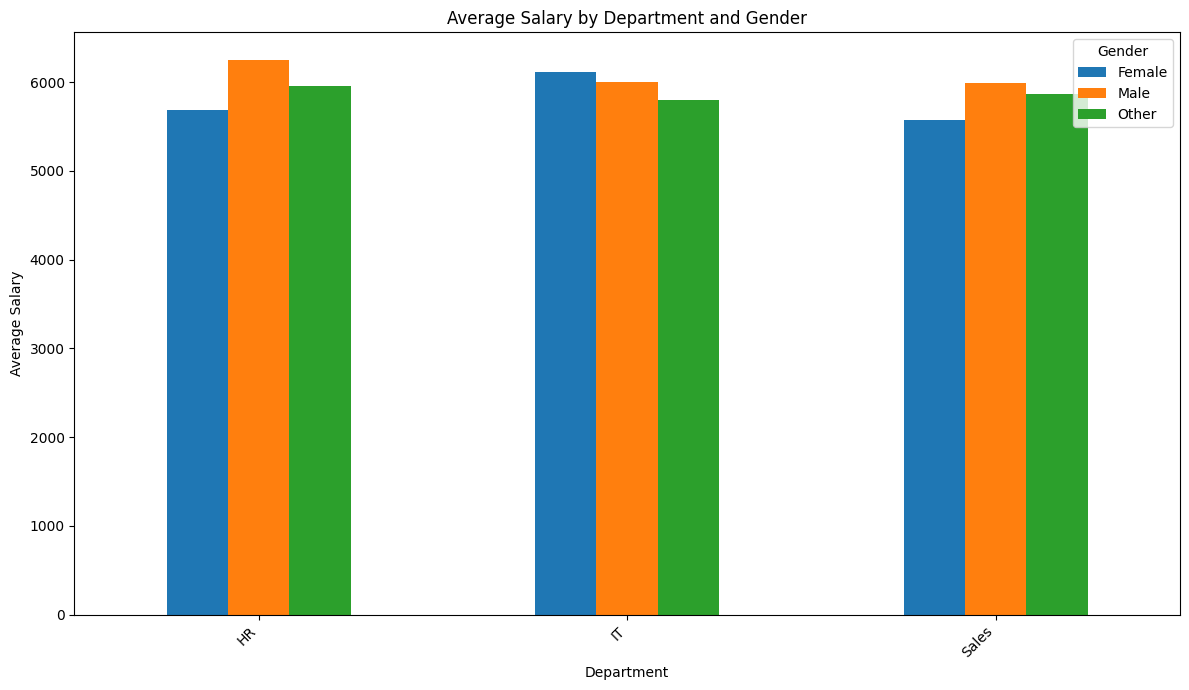

In [42]:
plt.figure(figsize=(12, 7))
ax = pivot_df_salary.plot(kind='bar', ax=plt.gca())
plt.ylabel("Average Salary")
plt.title("Average Salary by Department and Gender")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

* The average salary was calculated for each department and gender combination.
* The pivoted data shows the average salary for each gender within each department, with missing values filled with 0.
* The visualization effectively displays the average salary across different departments, segmented by gender.

### Insights or Next Steps

* Analyze the differences in average salaries between genders within each department to identify potential disparities.
* Investigate the reasons behind significant salary differences observed in certain departments.


## Department-wise Salary Distribution by Tenure

In [43]:
department_tenure_salary = df.groupBy("Department", "Tenure").agg(avg("Salary").alias("Average Salary"))
department_tenure_salary.show()

+----------+------+-----------------+
|Department|Tenure|   Average Salary|
+----------+------+-----------------+
|        HR|     8|6227.285714285715|
|        HR|     6|6143.363636363636|
|     Sales|     9|6101.416666666667|
|        HR|     2|5996.840909090909|
|     Sales|     4|5237.414634146341|
|        IT|    10|5308.911764705882|
|     Sales|    11|           7894.0|
|        IT|     3|5607.482758620689|
|     Sales|     3|           6181.3|
|        IT|     8|         6350.875|
|        HR|     5|5759.205882352941|
|     Sales|     5|5316.545454545455|
|        IT|     6|6116.354838709677|
|     Sales|     7|5665.181818181818|
|        IT|     7|6358.972222222223|
|        IT|     1|5787.241379310345|
|     Sales|     1|7022.741935483871|
|     Sales|     8|5854.428571428572|
|        HR|     3|6191.695652173913|
|        IT|     2|       5493.09375|
+----------+------+-----------------+
only showing top 20 rows



In [44]:
department_tenure_salary_pd = department_tenure_salary.toPandas()
pivot_df_tenure_salary = department_tenure_salary_pd.pivot(index='Department', columns='Tenure', values='Average Salary').fillna(0)
display(pivot_df_tenure_salary)

Tenure,1,2,3,4,5,6,7,8,9,10,11
Department,,,,,,,,,,,
HR,6278.892857,5996.840909,6191.695652,6068.024390,5759.205882,6143.363636,5854.419355,6227.285714,5341.500000,6190.280000,0.0
IT,5787.241379,5493.093750,5607.482759,6151.108108,6239.078947,6116.354839,6358.972222,6350.875000,6134.263158,5308.911765,5671.0
Sales,7022.741935,5672.545455,6181.300000,5237.414634,5316.545455,6194.812500,5665.181818,5854.428571,6101.416667,5038.896552,7894.0


## Visualize with grouped bar chart (Tenure)

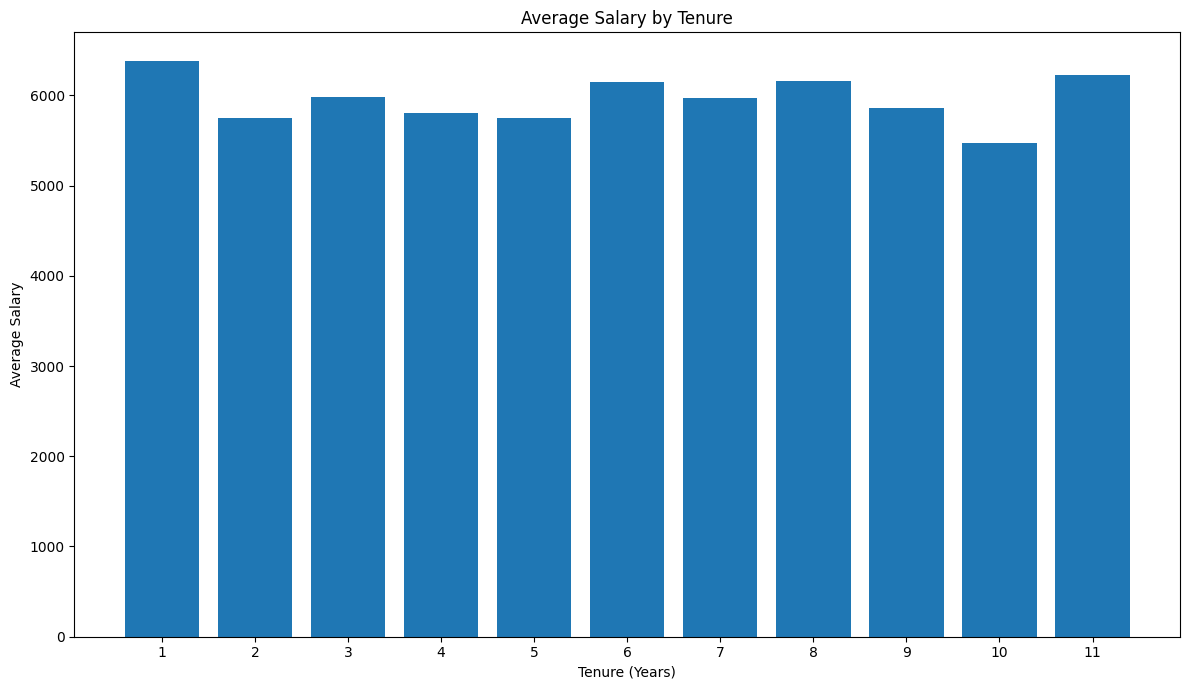

In [45]:
import matplotlib.pyplot as plt
import pandas as pd # Import pandas for plotting

# Group by Tenure and calculate the average salary
tenure_salary = df.groupBy("Tenure").agg(avg("Salary").alias("Average Salary"))

# Convert to Pandas DataFrame
tenure_salary_pd = tenure_salary.toPandas()

# Sort by Tenure for better visualization
tenure_salary_pd = tenure_salary_pd.sort_values(by='Tenure')

plt.figure(figsize=(12, 7))
# Create a bar plot of average salary vs tenure
plt.bar(tenure_salary_pd['Tenure'], tenure_salary_pd['Average Salary'])
plt.xlabel("Tenure (Years)")
plt.ylabel("Average Salary")
plt.title("Average Salary by Tenure")
plt.xticks(tenure_salary_pd['Tenure']) # Set ticks to be the tenure years
plt.tight_layout()
plt.show()

## Department-wise Salary Distribution by Status

In [46]:
department_status_salary = df.groupBy("Department", "Status").agg(avg("Salary").alias("Average Salary"))
department_status_salary.show()

+----------+--------+------------------+
|Department|  Status|    Average Salary|
+----------+--------+------------------+
|        HR|  Active| 5932.630573248408|
|        IT|Inactive|6016.7202380952385|
|        IT|  Active|  5920.87134502924|
|     Sales|Inactive| 5879.248484848485|
|     Sales|  Active| 5732.404624277457|
|        HR|Inactive| 6029.463855421687|
+----------+--------+------------------+



In [47]:
department_status_salary_pd = department_status_salary.toPandas()
pivot_df_status_salary = department_status_salary_pd.pivot(index='Department', columns='Status', values='Average Salary').fillna(0)
display(pivot_df_status_salary)

Status,Active,Inactive
Department,,
HR,5932.630573,6029.463855
IT,5920.871345,6016.720238
Sales,5732.404624,5879.248485


## Visualize with grouped bar chart (Status)

<Figure size 1200x700 with 0 Axes>

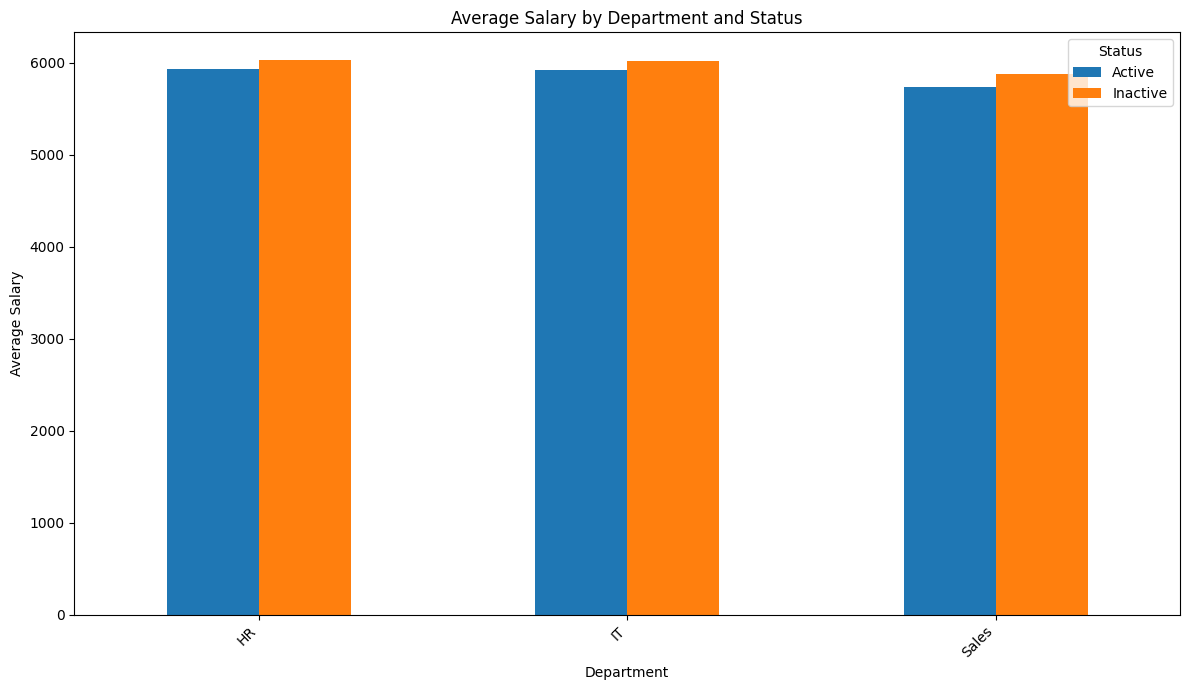

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
pivot_df_status_salary.plot(kind='bar', figsize=(12, 7))
plt.xlabel("Department")
plt.ylabel("Average Salary")
plt.title("Average Salary by Department and Status")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [49]:
df.show(50)

+---+--------------------+---+------+----------+------+------------+-----------------+----------+--------+-----------+-------+------+-----------+---------+
| ID|                Name|Age|Gender|Department|Salary|Joining Date|Performance Score|Experience|  Status|   Location|Session|Tenure|Session_Idx|GenderIdx|
+---+--------------------+---+------+----------+------+------------+-----------------+----------+--------+-----------+-------+------+-----------+---------+
|  1|        Cory Escobar| 48|Female|        HR|  5641|  2015-05-03|              2.0|        16|  Active|   New York|  Night|    10|        0.0|      1.0|
|  2|     Timothy Sanchez| 25| Other|     Sales|  4249|  2020-11-09|              2.0|        11|Inactive|Los Angeles|Evening|     5|        2.0|      0.0|
|  3|        Chad Nichols| 57| Other|     Sales|  3058|  2019-02-12|              2.0|         1|Inactive|   New York|Morning|     6|        1.0|      0.0|
|  4|  Christine Williams| 58|Female|        IT|  5895|  2017-09

In [50]:
from pyspark.ml.feature import VectorAssembler
feature_vec = VectorAssembler(inputCols = ["Experience","Tenure","Session_Idx","GenderIdx"],outputCol = "features")
df = feature_vec.transform(df)
df.show()

+---+------------------+---+------+----------+------+------------+-----------------+----------+--------+-----------+-------+------+-----------+---------+-------------------+
| ID|              Name|Age|Gender|Department|Salary|Joining Date|Performance Score|Experience|  Status|   Location|Session|Tenure|Session_Idx|GenderIdx|           features|
+---+------------------+---+------+----------+------+------------+-----------------+----------+--------+-----------+-------+------+-----------+---------+-------------------+
|  1|      Cory Escobar| 48|Female|        HR|  5641|  2015-05-03|              2.0|        16|  Active|   New York|  Night|    10|        0.0|      1.0|[16.0,10.0,0.0,1.0]|
|  2|   Timothy Sanchez| 25| Other|     Sales|  4249|  2020-11-09|              2.0|        11|Inactive|Los Angeles|Evening|     5|        2.0|      0.0| [11.0,5.0,2.0,0.0]|
|  3|      Chad Nichols| 57| Other|     Sales|  3058|  2019-02-12|              2.0|         1|Inactive|   New York|Morning|     6

In [51]:
train_df, test_df = df.randomSplit(weights=[0.8, 0.2], seed=42)

In [52]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="Salary")
lr_model = lr.fit(train_df)






### 5. Model Training and Evaluation

A Linear Regression model was trained to predict 'Salary' using the engineered features. The model's performance was evaluated on a test dataset using the following regression metrics:

*   **Root Mean Squared Error (RMSE):** Measures the average magnitude of the errors.
*   **Mean Absolute Error (MAE):** Measures the average absolute errors.
*   **R-squared (R2):** Represents the proportion of the variance in the dependent variable that is predictable from the independent variables.

Note: An "accuracy" metric was also calculated for demonstration purposes, but it is not a standard metric for regression models.

In [53]:
from pyspark.ml.evaluation import RegressionEvaluator

# Make predictions on the test data
predictions = lr_model.transform(test_df)

# Evaluate the model using RegressionEvaluator
evaluator_rmse = RegressionEvaluator(labelCol="Salary", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="Salary", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="Salary", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Root Mean Squared Error (RMSE): 2317.5245217697216
Mean Absolute Error (MAE): 1991.8377118178098
R-squared (R2): -0.001878853630638666
